In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2 
import networkx as nx 
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [5]:
def read_edges(filename,is_directed=False):
    file = open(filename, 'r',encoding='utf-8')
    lines = list(file.read().split("\n"))
    graph = nx.Graph()
    if is_directed:
        graph = nx.DiGraph()
    for line in lines :
        if line is None or line == '' or line == "\n":
            continue
        s,t,w = line.split()
        graph.add_edge(int(s),int(t),weight=float(w))
        s,t = int(s),int(t)
    return graph



graph = read_edges("./airports.edges",False)


In [6]:
def create_adjacency_matrix(graph):
    n = graph.number_of_nodes()
    adj_matrix = np.zeros((n,n))
    lookup_table = dict()
    index = 0
    for edge in graph.edges:
        if edge[0] not in lookup_table:
            lookup_table[edge[0]] = index
            index += 1
        if edge[1] not in lookup_table:
            lookup_table[edge[1]] = index
            index += 1  
        
        adj_matrix[lookup_table[edge[0]]][lookup_table[edge[1]]] = 1
        adj_matrix[lookup_table[edge[1]]][lookup_table[edge[0]]] = 1

    return adj_matrix,lookup_table

def create_degree_matrix(adj_matrix):
    n = adj_matrix.shape[0]
    degree_matrix = np.zeros((n,n))
    for i in range(n):
        degree_matrix[i][i] = np.sum(adj_matrix[i])
    return degree_matrix

def create_laplacian_matrix(adj_matrix):
    return create_degree_matrix(adj_matrix) - adj_matrix

adj_mat,lt = create_adjacency_matrix(graph)
degree_mat = create_degree_matrix(adj_mat)
laplacian_mat = create_laplacian_matrix(adj_mat)



In [10]:
e_values,e_vectors = np.linalg.eig(laplacian_mat)
e_values = np.real(e_values)
idx = e_values.argsort()
eigenValues = e_values[idx]
eigenVectors = e_vectors[:,idx]
_2_eigen_vector = np.real(eigenVectors[1])

out = open("P03-Eigens.txt","w")
out.write("2nd Eigen Value: "+str(e_values[1])+"\n")
out.write("2nd Eigen Vector: "+str(_2_eigen_vector.tolist()))
out.close()


100%|██████████| 9/9 [00:29<00:00,  3.23s/it]


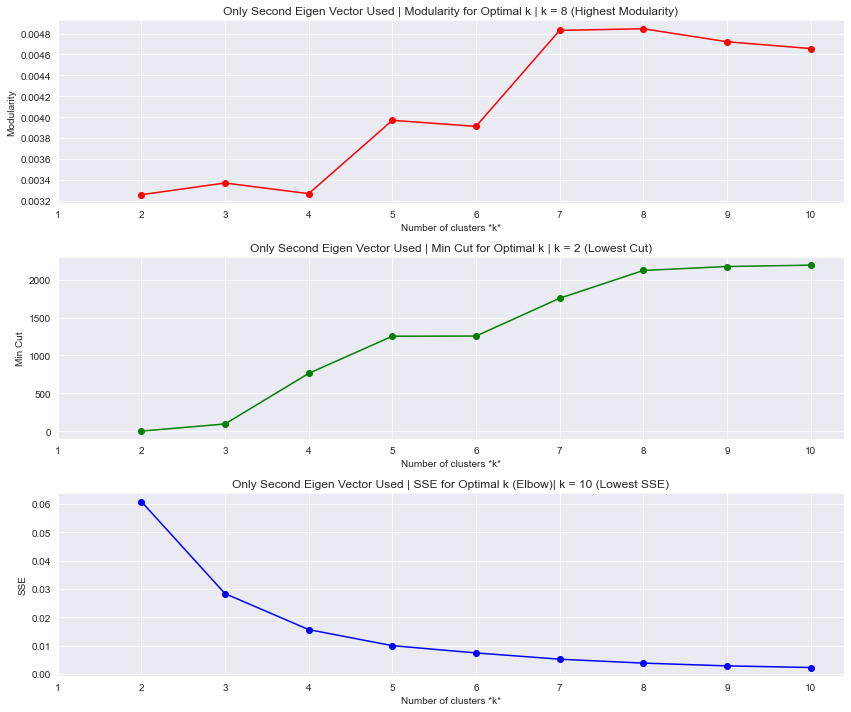

100%|██████████| 9/9 [00:33<00:00,  3.77s/it]


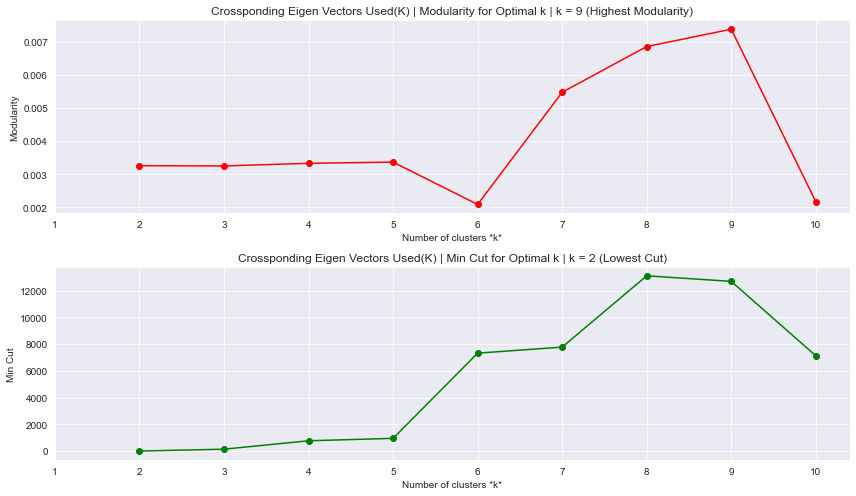

In [12]:
def calculate_modularity(graph,clusters):
    n = graph.number_of_nodes()
    m = graph.number_of_edges()
    adj_mat,lt = create_adjacency_matrix(graph)
    degree_mat = create_degree_matrix(adj_mat)
    modularity = 0
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            a_ij = 1 if adj_mat[i][j] == 1 else 0

            k_i = degree_mat[i,i]
            k_j = degree_mat[j,j]
            modularity += (a_ij - (k_i*k_j)/(2*m))*1 if clusters[i] == clusters[j] else 0

    return modularity/(2*m)

def calculate_min_cut(adj_mat,clusters):
    n = adj_mat.shape[0]
    min_cut = 0
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            a_ij = 1 if adj_mat[i][j] == 1 else 0
            min_cut += a_ij*1 if clusters[i] != clusters[j] else 0

    uni = np.unique(clusters)
    hist,_ = np.histogram(clusters,bins=len(uni))
    min_cut = min_cut/np.min(hist)

    return min_cut
    
def kmeans_measure(eigenVectors,graph,test=5,only_second=True):
    modularity = []
    min_cut = []
    sse = []
    test +=1
    for k in tqdm(range(2, test)):
        kmeans = KMeans(n_clusters=k)
        X = np.real(eigenVectors[1:k].T)
        if only_second:
            X = np.real(eigenVectors[1].reshape(-1,1))
        kmeans.fit(X)
        modularity.append(calculate_modularity(graph,kmeans.labels_))
        min_cut.append(calculate_min_cut(adj_mat,kmeans.labels_))
        sse.append(kmeans.inertia_)

    sns.set_style("darkgrid")
    if only_second:
        plt.figure(figsize=(12, 10))
    else:
        plt.figure(figsize=(12, 7))

    if only_second:
        cmd = "Only Second Eigen Vector Used | "
        I = 3
    else:
        cmd = "Crossponding Eigen Vectors Used(K) | "
        I = 2    

    plt.subplot(I, 1, 1)
    plt.plot(range(2, test), modularity, '-o',color='red')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Modularity')
    plt.xticks(range(1,test))
    plt.title("{1}Modularity for Optimal k | k = {0} (Highest Modularity)".format(np.argmax(modularity)+2,cmd))

    plt.subplot(I, 1, 2)
    plt.plot(range(2, test), min_cut, '-o',color='green')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Min Cut')
    plt.xticks(range(1,test))
    plt.title("{1}Min Cut for Optimal k | k = {0} (Lowest Cut)".format(np.argmin(min_cut)+2,cmd))

    if only_second:
        plt.subplot(I, 1, 3)
        plt.plot(range(2, test), sse, '-o',color='blue')
        plt.xlabel(r'Number of clusters *k*')
        plt.ylabel('SSE')
        plt.xticks(range(1,test))
        plt.title("{1}SSE for Optimal k (Elbow)| k = {0} (Lowest SSE)".format(np.argmin(sse)+2,cmd))

    plt.tight_layout()
    plt.show()


kmeans_measure(eigenVectors,graph,10,True)
kmeans_measure(eigenVectors,graph,10,False)